In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import plotsettings

### Figure 1c,d,e,f

#### E. coli MG1655, 1-file barcode pairing

In [37]:
%cd ../MG1655
Ecoli_contiglengths = []
numContigs = 0
with open("contig_lengths", "r") as f:
    for line in f:
        if float(line) > 1000:
            Ecoli_contiglengths.append(float(line))
            numContigs += 1
print numContigs, "longer than 1kb"

/Users/jimstapleton/Dropbox/Papers/Sequencing/Github/MG1655
2878 longer than 1kb


In [38]:
sumLength = 0
for contiglength in Ecoli_contiglengths:
    sumLength += contiglength

N50sum = 0
for contiglength in Ecoli_contiglengths:
    N50sum += contiglength
    if N50sum/float(sumLength) > 0.5:
        print "N50 is", contiglength
        break

N50 is 5980.0


In [40]:
data = []
with open("histogram.txt", "r") as f:
    for line in f:
        data.append(float(line))
print "The complexity is", len(data)

The complexity is 2792


### Mismatch rate calculation

In [46]:
# Parse the cigar and MD fields of the alignment SAM file to calculate percent identity

%cd ../MG1655
Match = 0
Softclip = 0
Mismatch = 0
Deletion = 0
Insertion = 0
N = 0
Hardclip = 0
Padding = 0
AC = 0
AG = 0
AT = 0
CA = 0
CG = 0
CT = 0
GA = 0
GC = 0
GT = 0
TA = 0
TC = 0
TG = 0
mismatchPositions = []
alignedSequences = 0
insertionPositions = []
deletionPositions = []
insertionRelativePositions = []
deletionRelativePositions = []

def is_number(s):
    '''http://stackoverflow.com/questions/354038/how-do-i-check-if-a-string-is-a-number-in-python'''
    try:
        int(s)
        return True
    except ValueError:
        return False
    
def magic(numList):
    '''http://stackoverflow.com/questions/489999/python-convert-list-of-ints-to-one-number'''
    s = ''.join(map(str, numList))
    return int(s)

with open('filteredalignMG1655.sam', 'r') as datafile:
    for line in datafile:
        alignedSequences += 1
        fields = line.split()
        if fields[0][:4] == 'NODE':
            
            # parse the cigar field to find number of matches, indels, etc
            cigar = fields[5]
            buildNum = []
            currentPosition = 0 
            startSoft = 0
            for char in cigar:
                if is_number(char):
                    buildNum.append(char)
                elif char == 'M':
                    Match += magic(buildNum)         # this is matches + mismatches = alignment matches
                    currentPosition += magic(buildNum)
                    buildNum = []
                elif char == 'S':
                    Softclip += magic(buildNum)
                    # keep track of soft clipping at the start of a read
                    if currentPosition == 0:
                        startSoft = magic(buildNum)
                    buildNum = []
                elif char == 'N':
                    N += magic(buildNum)
                    buildNum = []         
                elif char == 'H':
                    Hardclip += magic(buildNum)
                    buildNum = []  
                elif char == 'P':
                    Padding += magic(buildNum)
                    buildNum = [] 
                elif char == 'D':
                    Deletion += magic(buildNum)
                    for i in xrange(magic(buildNum)):
                        deletionPositions.append(currentPosition)
                    buildNum = []  
                elif char == 'I':
                    Insertion += magic(buildNum)
                    for i in xrange(magic(buildNum)):
                        insertionPositions.append(currentPosition)
                        currentPosition += 1
                    buildNum = []
            totalLength = currentPosition
            
            for position in insertionPositions:
                insertionRelativePositions.append(float(position)/totalLength)
            for position in deletionPositions:
                deletionRelativePositions.append(float(position)/totalLength)                

                    
            # parse the MD:Z field for mismatches, 
            # deletions are marked with ^, insertions aren't recorded
            MD = fields[12]
            deleteflag = 0
            buildNum = []
            currentPosition = startSoft
            for char in MD[5:]: # skip the fixed MD:Z: start
                if deleteflag:
                    if is_number(char): 
                        deleteflag = 0 # --> start of next range, reset
                        buildNum.append(char)                       
                elif char == '^': # marks a deletion
                    deleteflag = 1
                    currentPosition += magic(buildNum)
                    buildNum = []
                elif not is_number(char):
                    Mismatch += 1
                    currentPosition += magic(buildNum)+1
                    mismatchRelativePosition = (currentPosition-startSoft)/float(totalLength)
                    mismatchPositions.append(mismatchRelativePosition)
                    buildNum = []
                    newBase = fields[9][currentPosition-1]
                    originalBase = char
                    if originalBase == 'A':
                        if newBase == 'C':
                            AC += 1
                        elif newBase == 'G':
                            AG += 1
                        elif newBase == 'T':
                            AT += 1    
                    if originalBase == 'C':
                        if newBase == 'A':
                            CA += 1
                        elif newBase == 'G':
                            CG += 1
                        elif newBase == 'T':
                            CT += 1
                    if originalBase == 'G':
                        if newBase == 'A':
                            GA += 1
                        elif newBase == 'C':
                            GC += 1
                        elif newBase == 'T':
                            GT += 1                        
                    if originalBase == 'T':
                        if newBase == 'A':
                            TA += 1
                        elif newBase == 'C':
                            TC += 1
                        elif newBase == 'G':
                            TG += 1                          
                else:
                    buildNum.append(char)
                    
            insertionPositions = []
            deletionPositions = []


        
print 'Alignment Matches =', Match
print 'Mismatches =', Mismatch
print 'Deletions =', Deletion
print 'Insertions =', Insertion
print 'N =', N
print 'Softclip =', Softclip
print 'Hardclip =', Hardclip
print 'Totalclip =', Softclip + Hardclip
print 'Padding =', Padding

print AC/float(Mismatch), AG/float(Mismatch), AT/float(Mismatch)
print CA/float(Mismatch), CG/float(Mismatch), CT/float(Mismatch)
print GA/float(Mismatch), GC/float(Mismatch), GT/float(Mismatch)
print TA/float(Mismatch), TC/float(Mismatch), TG/float(Mismatch)
print AC+AG+AT+ CA+CG+CT+ GA+ GC+ GT+ TA+ TC+ TG
print "Transition sum =", (CT+TC+AG+GA)/float(Mismatch)


print 'Total bases aligned =', (Match+Deletion+Insertion)
print 'Fraction clipped =', float(Softclip+Hardclip)/(Softclip+Hardclip+Match+Deletion+Insertion)
print 'Accuracy without clipping =', 1-float(Mismatch+Deletion+Insertion+Softclip+Hardclip)/(Match+Deletion+Insertion+Softclip+Hardclip)
print 'Accuracy with clipping =', 1-float(Mismatch+Deletion+Insertion)/(Match+Deletion+Insertion)
print 'Mismatch rate =', float(Mismatch)/(Match+Deletion+Insertion)
print 'Insertion rate =', float(Insertion)/(Match+Deletion+Insertion) 
print 'Deletion rate =', float(Deletion)/(Match+Deletion+Insertion) 

print 'Number of aligned sequences =', alignedSequences

/Users/jimstapleton/Dropbox/Papers/Sequencing/Github/MG1655
Alignment Matches = 10162249
Mismatches = 3897
Deletions = 545
Insertions = 23
N = 0
Softclip = 276021
Hardclip = 929840
Totalclip = 1205861
Padding = 0
0.0225814729279 0.250705671029 0.0628688734924
0.0272004105722 0.0153964588145 0.108545034642
0.104952527585 0.0128303823454 0.0266871952784
0.052861175263 0.292019502181 0.0192455735181
3881
Transition sum = 0.756222735438
Total bases aligned = 10162817
Fraction clipped = 0.106068709132
Accuracy without clipping = 0.893538545115
Accuracy with clipping = 0.999560653311
Mismatch rate = 0.000383456673479
Insertion rate = 2.26315203747e-06
Deletion rate = 5.36268634966e-05
Number of aligned sequences = 4769


#### Mismatch rate of reads with 100 bp trimmed from each end

In [329]:
# Parse the cigar and MD fields of the alignment SAM file to calculate percent identity

%cd ../MG1655
Match = 0
Softclip = 0
Mismatch = 0
Deletion = 0
Insertion = 0
N = 0
Hardclip = 0
Padding = 0
AC = 0
AG = 0
AT = 0
CA = 0
CG = 0
CT = 0
GA = 0
GC = 0
GT = 0
TA = 0
TC = 0
TG = 0
mismatchPositions = []
alignedSequences = 0
insertionPositions = []
deletionPositions = []
insertionRelativePositions = []
deletionRelativePositions = []

def is_number(s):
    '''http://stackoverflow.com/questions/354038/how-do-i-check-if-a-string-is-a-number-in-python'''
    try:
        int(s)
        return True
    except ValueError:
        return False
    
def magic(numList):
    '''http://stackoverflow.com/questions/489999/python-convert-list-of-ints-to-one-number'''
    s = ''.join(map(str, numList))
    return int(s)

with open('tfalignMG1655.sam', 'r') as datafile:
    for line in datafile:
        alignedSequences += 1
        fields = line.split()
        if fields[0][:4] == 'NODE':
            
            # parse the cigar field to find number of matches, indels, etc
            cigar = fields[5]
            buildNum = []
            currentPosition = 0 
            startSoft = 0
            for char in cigar:
                if is_number(char):
                    buildNum.append(char)
                elif char == 'M':
                    Match += magic(buildNum)         # this is matches + mismatches = alignment matches
                    currentPosition += magic(buildNum)
                    buildNum = []
                elif char == 'S':
                    Softclip += magic(buildNum)
                    # keep track of soft clipping at the start of a read
                    if currentPosition == 0:
                        startSoft = magic(buildNum)
                    buildNum = []
                elif char == 'N':
                    N += magic(buildNum)
                    buildNum = []         
                elif char == 'H':
                    Hardclip += magic(buildNum)
                    buildNum = []  
                elif char == 'P':
                    Padding += magic(buildNum)
                    buildNum = [] 
                elif char == 'D':
                    Deletion += magic(buildNum)
                    for i in xrange(magic(buildNum)):
                        deletionPositions.append(currentPosition)
                    buildNum = []  
                elif char == 'I':
                    Insertion += magic(buildNum)
                    for i in xrange(magic(buildNum)):
                        insertionPositions.append(currentPosition)
                        currentPosition += 1
                    buildNum = []
            totalLength = currentPosition
            
            for position in insertionPositions:
                insertionRelativePositions.append(float(position)/totalLength)
            for position in deletionPositions:
                deletionRelativePositions.append(float(position)/totalLength)                

                    
            # parse the MD:Z field for mismatches, 
            # deletions are marked with ^, insertions aren't recorded
            MD = fields[12]
            deleteflag = 0
            buildNum = []
            currentPosition = startSoft
            for char in MD[5:]: # skip the fixed MD:Z: start
                if deleteflag:
                    if is_number(char): 
                        deleteflag = 0 # --> start of next range, reset
                        buildNum.append(char)                       
                elif char == '^': # marks a deletion
                    deleteflag = 1
                    currentPosition += magic(buildNum)
                    buildNum = []
                elif not is_number(char):
                    Mismatch += 1
                    currentPosition += magic(buildNum)+1
                    mismatchRelativePosition = (currentPosition-startSoft)/float(totalLength)
                    mismatchPositions.append(mismatchRelativePosition)
                    buildNum = []
                    newBase = fields[9][currentPosition-1]
                    originalBase = char
                    if originalBase == 'A':
                        if newBase == 'C':
                            AC += 1
                        elif newBase == 'G':
                            AG += 1
                        elif newBase == 'T':
                            AT += 1    
                    if originalBase == 'C':
                        if newBase == 'A':
                            CA += 1
                        elif newBase == 'G':
                            CG += 1
                        elif newBase == 'T':
                            CT += 1
                    if originalBase == 'G':
                        if newBase == 'A':
                            GA += 1
                        elif newBase == 'C':
                            GC += 1
                        elif newBase == 'T':
                            GT += 1                        
                    if originalBase == 'T':
                        if newBase == 'A':
                            TA += 1
                        elif newBase == 'C':
                            TC += 1
                        elif newBase == 'G':
                            TG += 1                          
                else:
                    buildNum.append(char)
                    
            insertionPositions = []
            deletionPositions = []


        
print 'Alignment Matches =', Match
print 'Mismatches =', Mismatch
print 'Deletions =', Deletion
print 'Insertions =', Insertion
print 'N =', N
print 'Softclip =', Softclip
print 'Hardclip =', Hardclip
print 'Totalclip =', Softclip + Hardclip
print 'Padding =', Padding

print AC/float(Mismatch), AG/float(Mismatch), AT/float(Mismatch)
print CA/float(Mismatch), CG/float(Mismatch), CT/float(Mismatch)
print GA/float(Mismatch), GC/float(Mismatch), GT/float(Mismatch)
print TA/float(Mismatch), TC/float(Mismatch), TG/float(Mismatch)
print AC+AG+AT+ CA+CG+CT+ GA+ GC+ GT+ TA+ TC+ TG
print "Transition sum =", (CT+TC+AG+GA)/float(Mismatch)


print 'Total bases aligned =', (Match+Deletion+Insertion)
print 'Fraction clipped =', float(Softclip+Hardclip)/(Softclip+Hardclip+Match+Deletion+Insertion)
print 'Accuracy without clipping =', 1-float(Mismatch+Deletion+Insertion+Softclip+Hardclip)/(Match+Deletion+Insertion+Softclip+Hardclip)
print 'Accuracy with clipping =', 1-float(Mismatch+Deletion+Insertion)/(Match+Deletion+Insertion)
print 'Mismatch rate =', float(Mismatch)/(Match+Deletion+Insertion)
print 'Insertion rate =', float(Insertion)/(Match+Deletion+Insertion) 
print 'Deletion rate =', float(Deletion)/(Match+Deletion+Insertion) 

print 'Number of aligned sequences =', alignedSequences

/Users/jimstapleton/NGS/140502HiSeq/final/P20EM4/singleFileNoFlashUseFwdUn
Alignment Matches = 9733945
Mismatches = 3076
Deletions = 518
Insertions = 20
N = 0
Softclip = 239825
Hardclip = 496929
Totalclip = 736754
Padding = 0
0.018855656697 0.250325097529 0.0614434330299
0.0217815344603 0.0113784135241 0.115084525358
0.106306892068 0.0107282184655 0.0227568270481
0.0481144343303 0.31144343303 0.0169050715215
3061
Transition sum = 0.783159947984
Total bases aligned = 9734483
Fraction clipped = 0.0703597865276
Accuracy with clipping = 0.929295077554
Accuracy without clipping = 0.999628742482
Mismatch rate = 0.000315990073638
Insertion rate = 2.0545518442e-06
Deletion rate = 5.32128927648e-05
Number of aligned sequences = 2410


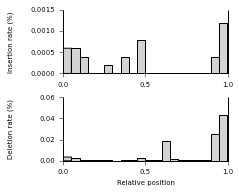

In [47]:
publishable = plotsettings.Set('Science') 
publishable.set_figsize(n_columns = 1.5, n_rows = 2)

labelx = -0.3

fig, ax = plt.subplots()

ax2 = plt.subplot(211)
numBins = 20
averageLength = (Match+Deletion+Insertion)/alignedSequences
binSize = averageLength/numBins
scaleToErrorRate = np.ones_like(insertionRelativePositions)/(binSize*alignedSequences)*100
plt.hist(insertionRelativePositions, weights=scaleToErrorRate, bins=numBins, color='lightgray')
ax2.set_ylabel("Insertion rate (%)")
plt.locator_params(nbins=4)
ax2.spines['top'].set_visible(False)
ax2.xaxis.set_ticks_position('bottom')
ax2.yaxis.set_ticks_position('left')
ax2.get_yaxis().set_label_coords(labelx, 0.5)
ax2.tick_params(axis='both', which='major', direction='out')


ax3 = plt.subplot(212)
numBins = 20
averageLength = (Match+Deletion+Insertion)/alignedSequences
binSize = averageLength/numBins
scaleToErrorRate = np.ones_like(deletionRelativePositions)/(binSize*alignedSequences)*100
plt.hist(deletionRelativePositions, weights=scaleToErrorRate, bins=numBins, color='lightgray')
ax3.set_xlabel("Relative position")
ax3.set_ylabel("Deletion rate (%)")
plt.locator_params(nbins=3)
ax3.spines['top'].set_visible(False)
ax3.xaxis.set_ticks_position('bottom')
ax3.yaxis.set_ticks_position('left')
ax3.get_yaxis().set_label_coords(labelx, 0.5)
ax3.tick_params(axis='both', which='major', direction='out')


plt.tight_layout()
plt.show()
#plt.savefig('ErrorPofile.pdf', format='pdf')

#### Jasmine length distribution

In [30]:
%cd ../Gelsemium/
Jasmine_contiglengths = []
numContigs = 0
with open("contig_lengths", "r") as f:
    for line in f:
        if float(line) > 1500:
            Jasmine_contiglengths.append(float(line))
            numContigs += 1
print numContigs, "longer than 1.5 kb"

/Users/jimstapleton/Dropbox/Papers/Sequencing/Github/Gelsemium
111054 longer than 1.5 kb


In [31]:
sumLength = 0
for contiglength in Jasmine_contiglengths:
    sumLength += contiglength

N50sum = 0
for contiglength in Jasmine_contiglengths:
    N50sum += contiglength
    if N50sum/float(sumLength) > 0.5:
        print "N50 is", contiglength
        break

N50 is 4251.0


In [32]:
Jasmine_contiglengths = []
numContigs = 0
with open("contig_lengths", "r") as f:
    for line in f:
        if float(line) > 1000:
            Jasmine_contiglengths.append(float(line))
            numContigs += 1
print numContigs, "longer than 1 kb"

149447 longer than 1 kb


In [33]:
sumLength = 0
for contiglength in Jasmine_contiglengths:
    sumLength += contiglength

N50sum = 0
for contiglength in Jasmine_contiglengths:
    N50sum += contiglength
    if N50sum/float(sumLength) > 0.5:
        print "N50 is", contiglength
        break

N50 is 3936.0


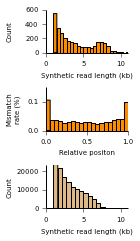

In [48]:
publishable = plotsettings.Set('Science')
publishable.set_figsize(n_columns = 1, n_rows = 2.5)

fig, ax = plt.subplots()
plt.subplots_adjust(hspace = 2)

labelx = -0.4

ax1 = plt.subplot(311)
ECplotlengths = [contiglength/(float(1000)) for contiglength in Ecoli_contiglengths]
plt.hist(ECplotlengths, bins=25, color='darkorange')
plt.axis([0,11,0,600])
plt.xlabel("Synthetic read length (kb)")
plt.ylabel("Count")
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
plt.locator_params(nbins=4)
plt.tick_params(axis='both', which='major', direction='out')
ax1.yaxis.set_label_coords(labelx, 0.5)


ax2 = plt.subplot(312)
numBins = 20
averageLength = (Match+Deletion+Insertion)/alignedSequences
binSize = averageLength/numBins
scaleToErrorRate = np.ones_like(mismatchPositions)/(binSize*alignedSequences)*100
plt.hist(mismatchPositions, weights=scaleToErrorRate, bins=numBins, color='darkorange')
ax1.get_yaxis().set_label_coords(labelx, 0.5)
plt.axis([0,1,0,0.15])
plt.xlabel("Relative positon")
plt.ylabel("Mismatch\nrate (%)")
plt.locator_params(nbins=2)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.xaxis.set_ticks_position('bottom')
ax2.yaxis.set_ticks_position('left')
plt.tick_params(axis='both', which='major', direction='out')
ax2.yaxis.set_label_coords(labelx+.09, 0.5)


ax3 = plt.subplot(313)
JEplotlengths = [contiglength/(float(1000)) for contiglength in Jasmine_contiglengths]
plt.hist(JEplotlengths, bins=25, color='burlywood')
plt.axis([0,11,0,23000])
plt.xlabel("Synthetic read length (kb)")
plt.ylabel("Count")
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.xaxis.set_ticks_position('bottom')
ax3.yaxis.set_ticks_position('left')
plt.tick_params(axis='both', which='major', direction='out')
ax3.yaxis.set_label_coords(labelx, 0.5)
plt.locator_params(nbins=4)

plt.tight_layout()

plt.show()
#plt.savefig('Ecoli_Jasmine_contigLengthHistogram.pdf', format='pdf')

#### Multiplexed experiment

In [5]:
%cd ../multiplex/
totalLongContigs = 0
N50dist = []
lengthlist = []

for i in range(1,25):
    contiglengths = []
    numContigs = 0
    sumLength = 0
    print "Strain #"+ str(i) +":"
    with open("contig_lengths_" + str(i), "r") as f:
        for line in f:
            if float(line) > 1000:
                contiglengths.append(float(line)/1000)
                numContigs += 1
    for contiglength in contiglengths:
        sumLength += contiglength
        
    lengthlist.append(float(sumLength)/4600)
    print numContigs, "longer than 1kb"
    totalLongContigs += numContigs
    N50sum = 0
    for contiglength in contiglengths:
        N50sum += contiglength
        if N50sum/float(sumLength) > 0.5:
            print "N50 is", contiglength, 'kb\n'
            N50dist.append(contiglength)
            break
            
print "Total contigs >1kb: " + str(totalLongContigs)
            
print "Median N50 is", np.median(N50dist)
print "Median E. coli genome coverage is", np.median(lengthlist)
            
print N50dist
print lengthlist
print "Average genome coverage is", np.average(lengthlist)

/Users/jimstapleton/Dropbox/Papers/Sequencing/Github/multiplex
Strain #1:
2868 longer than 1kb
N50 is 3.921 kb

Strain #2:
2366 longer than 1kb
N50 is 4.218 kb

Strain #3:
7262 longer than 1kb
N50 is 3.866 kb

Strain #4:
4673 longer than 1kb
N50 is 3.914 kb

Strain #5:
7782 longer than 1kb
N50 is 3.746 kb

Strain #6:
1454 longer than 1kb
N50 is 4.319 kb

Strain #7:
5766 longer than 1kb
N50 is 3.749 kb

Strain #8:
4806 longer than 1kb
N50 is 3.976 kb

Strain #9:
800 longer than 1kb
N50 is 4.487 kb

Strain #10:
508 longer than 1kb
N50 is 4.204 kb

Strain #11:
5253 longer than 1kb
N50 is 3.776 kb

Strain #12:
6325 longer than 1kb
N50 is 3.796 kb

Strain #13:
3654 longer than 1kb
N50 is 4.137 kb

Strain #14:
2634 longer than 1kb
N50 is 5.084 kb

Strain #15:
5031 longer than 1kb
N50 is 4.243 kb

Strain #16:
2985 longer than 1kb
N50 is 4.269 kb

Strain #17:
830 longer than 1kb
N50 is 5.231 kb

Strain #18:
4720 longer than 1kb
N50 is 4.123 kb

Strain #19:
2860 longer than 1kb
N50 is 2.457 kb


/Users/jimstapleton/Dropbox/Papers/Sequencing/Github/multiplex
/Users/jimstapleton/Dropbox/Papers/Sequencing/Figures


/Users/jimstapleton/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/font_manager.py:1236: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


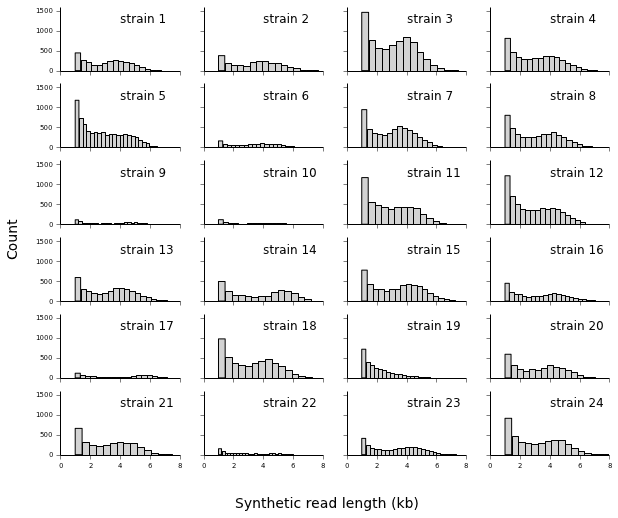

In [6]:
%cd ../multiplex/
publishable = plotsettings.Set('Science')
publishable.set_figsize(n_columns = 4, n_rows = 6)

x = np.arange(0,10.0, 0.1)
fig, ax = plt.subplots(6,4, sharex=True, sharey=True)
#fig.subplots_adjust(hspace = 500, wspace=100)

for i, a in enumerate(ax.flatten()):
    contiglengths = []
    with open("contig_lengths_" + str(i+1), "r") as f:
        for line in f:
            if float(line) > 1000:
                contiglengths.append(float(line))
    plotlengths = [contiglength/(float(1000)) for contiglength in contiglengths]
    a.hist(plotlengths, bins=25, color='lightgray')
    a.axis([0,8,0,1600])
    a.locator_params(nbins=4)
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    a.xaxis.set_ticks_position('bottom')
    a.yaxis.set_ticks_position('left')
    a.tick_params(axis='both', which='major', direction='out')
    a.text(4, 1200, 'strain ' + str(i+1), fontsize=12)

    
fig.text(0.5, 0.04, "Synthetic read length (kb)", ha='center', va='center', size=14)
fig.text(0.06, 0.5, "Count", ha='center', va='center', rotation='vertical', size=14)

plt.show()
#plt.savefig('Multiplex_contigLengthHistograms.pdf', format='pdf')

In [8]:
# Sum and genome coverage of all synthetic reads, including shorter than 1kb
totalbases = [11395127,
9884353,
28519530,
18538996,
30678310,
6172961,
22015177,
19020660,
4428893,
2675525,
20549003,
24682192,
14881125,
11922925,
20566605,
12144709,
3890909,
19092366,
10752461,
13204740,
13351822,
3776251,
12617665,
17003027]
print [totalbase/float(4600000) for totalbase in totalbases]

[2.4772015217391306, 2.1487723913043477, 6.199897826086956, 4.03021652173913, 6.669197826086957, 1.341948043478261, 4.785908043478261, 4.134926086956522, 0.9628028260869566, 0.5816358695652174, 4.467174565217391, 5.365693913043478, 3.2350271739130436, 2.591940217391304, 4.471001086956521, 2.6401541304347824, 0.8458497826086957, 4.150514347826087, 2.3374915217391306, 2.870595652173913, 2.90257, 0.8209241304347826, 2.7429706521739132, 3.6963102173913045]


In [9]:
# Trimmed reads demultiplexed to each strain
readcounts = [
8872508,
11930637,
10809493,
7954228,
10911001,
6665185,
13681197,
8853848,
9302047,
7254760,
8048677,
8929129,
9800591,
10318263,
14214396,
8038491,
4071121,
9047392,
2093789,
6834299,
7798683,
1060475,
8673609,
6553945]

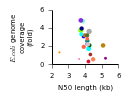

In [10]:
publishable = plotsettings.Set('Science')
publishable.set_figsize(n_columns = .9, n_rows =1)

fig = plt.figure()

labelx = -0.5
ax = plt.subplot(111)
scaledreadcounts = [count/float(500000) for count in readcounts]
lotsocolors = ['tomato',
'aqua',
'aquamarine',
'blue',
'blueviolet',
'brown',
'chartreuse',
'chocolate',
'coral',
'crimson',
'cyan',
'darkblue',
'darkcyan',
'darkgoldenrod',
'darkgray',
'darkgreen',
'darkmagenta',
'darkolivegreen',
'darkorange',
'darkorchid',
'darkseagreen',
'deeppink',
'thistle'
]
plt.scatter(N50dist, lengthlist, s=scaledreadcounts, facecolors=lotsocolors, edgecolors='none')
plt.xlabel("N50 length (kb)")
plt.ylabel("$E. coli$ genome\ncoverage\n(fold)")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.yaxis.set_label_coords(labelx+.22, 0.5)
plt.tick_params(axis='both', which='major', direction='out')
plt.locator_params(nbins=4)
plt.tight_layout()

plt.show()
#plt.savefig('Multiplex.pdf', format='pdf')

### Figure 2: mRNA length histograms

In [5]:
%cd ../HCT116/
HCTcontiglengths = []
numContigs = 0
with open("contig_lengths", "r") as f:
    for line in f:
        if float(line) > 1000:
            HCTcontiglengths.append(float(line))
            numContigs += 1
print numContigs, "longer than 1000 bp"

/Users/jimstapleton/Dropbox/Papers/Sequencing/Github/HCT116
11707 longer than 1000 bp


In [6]:
sumLength = 0
for contiglength in HCTcontiglengths:
    sumLength += contiglength

N50sum = 0
for contiglength in HCTcontiglengths:
    N50sum += contiglength
    if N50sum/float(sumLength) > 0.5:
        print "N50 is", contiglength
        break

N50 is 1465.0


In [7]:
%cd ../HCT116/
HCTcontiglengths = []
numContigs = 0
with open("contig_lengths", "r") as f:
    for line in f:
        if float(line) > 500:
            HCTcontiglengths.append(float(line))
            numContigs += 1
print numContigs, "longer than 500 bp"

/Users/jimstapleton/Dropbox/Papers/Sequencing/Github/HCT116
28689 longer than 500 bp


In [12]:
%cd ../HepG2/
Hepcontiglengths = []
numContigs = 0
with open("contig_lengths", "r") as f:
    for line in f:
        if float(line) > 1000:
            Hepcontiglengths.append(float(line))
            numContigs += 1
print numContigs, "longer than 1000 bp"

/Users/jimstapleton/Dropbox/Papers/Sequencing/Github/HepG2
6640 longer than 1000 bp


In [13]:
sumLength = 0
for contiglength in Hepcontiglengths:
    sumLength += contiglength

N50sum = 0
for contiglength in Hepcontiglengths:
    N50sum += contiglength
    if N50sum/float(sumLength) > 0.5:
        print "N50 is", contiglength
        break

N50 is 1639.0


In [14]:
%cd ../HepG2/
Hepcontiglengths = []
numContigs = 0
with open("contig_lengths", "r") as f:
    for line in f:
        if float(line) > 500:
            Hepcontiglengths.append(float(line))
            numContigs += 1
print numContigs, "longer than 500 bp"

/Users/jimstapleton/Dropbox/Papers/Sequencing/Github/HepG2
16929 longer than 500 bp


/Users/jimstapleton/Dropbox/Papers/Sequencing/Figures


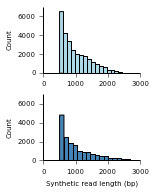

In [421]:
publishable = plotsettings.Set('Science')
publishable.set_figsize(n_columns = 1, n_rows = 2)

fig, ax = plt.subplots()

ax1 = plt.subplot(211)
plt.hist(HCTcontiglengths, bins=20, color='lightblue')
plt.axis([0,3000,0,7000])
plt.ylabel("Count")
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
plt.tick_params(axis='both', which='major', direction='out')
plt.locator_params(nbins=4)

ax2 = plt.subplot(212)
plt.hist(Hepcontiglengths, bins=30, color='steelblue')
plt.axis([0,3000,0,7000])
plt.xlabel("Synthetic read length (kb)")
plt.ylabel("Count")
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.xaxis.set_ticks_position('bottom')
ax2.yaxis.set_ticks_position('left')
plt.tick_params(axis='both', which='major', direction='out')
plt.locator_params(nbins=4)
plt.tight_layout()


plt.show()
#plt.savefig('mRNA_length.pdf', format='pdf')

/Users/jimstapleton/Dropbox/Papers/Sequencing/Figures


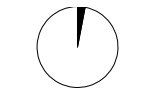

In [124]:
publishable = plotsettings.Set('Science')
publishable.set_figsize(n_columns = 1, n_rows = 1)

sizes = [97,3]
colors = ['white', 'black']

plt.pie(sizes, colors=colors,
        shadow=False, startangle=90)
plt.axis('equal')
plt.tight_layout()


plt.show()
#plt.savefig('mRNA_pie.pdf', format='pdf')

In [36]:
short_junctions = []
with open('HCT_read_blocks.txt', 'r') as data:
    for line in data:
        for datafield in line.split('\r'):
            short_junctions.append(int(datafield.rstrip())-1)

with open('Hep_read_blocks.txt', 'r') as data:
   for line in data:
        for datafield in line.split('\r'):
            short_junctions.append(int(datafield.rstrip())-1)
print len(short_junctions)

HCT_long_junctions = []
with open('HCT_long_read_blocks.txt', 'r') as data:
   for line in data:
        for datafield in line.split('\r'):
            HCT_long_junctions.append(int(datafield.rstrip())-1)
print len(HCT_long_junctions)

Hep_long_junctions = []
with open('Hep_long_read_blocks.txt', 'r') as data:
   for line in data:
        for datafield in line.split('\r'):
            Hep_long_junctions.append(int(datafield.rstrip())-1)
print len(Hep_long_junctions)


print np.median(np.array(short_junctions))
print np.median(np.array(HCT_long_junctions))
print np.median(np.array(Hep_long_junctions))

/Users/jimstapleton/Dropbox/Papers/Sequencing/Github
6952
24858
16202
0.0
2.0
2.0


/Users/jimstapleton/Dropbox/Papers/Sequencing/Figures


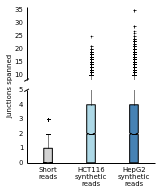

In [122]:
publishable = plotsettings.Set('Science')
publishable.set_figsize(n_columns = 1, n_rows = 2)

#http://nbviewer.ipython.org/gist/olgabot/5432378
#http://blog.bharatbhole.com/creating-boxplots-with-matplotlib/

data_to_plot = [short_junctions, HCT_long_junctions, Hep_long_junctions]
fig = plt.figure()
ax = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
bp = ax.boxplot(data_to_plot, widths=.2, notch=True, patch_artist=True)
bp2 = ax2.boxplot(data_to_plot, widths=.2, notch=True, patch_artist=True)
ax.set_xticklabels('')
ax2.set_xticklabels(['Short\nreads', 'HCT116\nsynthetic\nreads', 
                    'HepG2\nsynthetic\nreads'])
#ax.set_yscale('log')
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax2.xaxis.set_ticks_position('none')
ax2.yaxis.set_ticks_position('none')

ax.set_ylim(8,36)
ax2.set_ylim(0,5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.setp(bp['whiskers'], linestyle='solid', color='black', linewidth=0.5)
plt.setp(bp['fliers'], color='black')
plt.setp(bp['caps'], color='black')
colors = ['lightgrey', 'lightblue', 'steelblue']
    
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
plt.setp(bp2['whiskers'], linestyle='solid', color='black', linewidth=0.5)
plt.setp(bp2['medians'], color='black')
plt.setp(bp2['fliers'], color='black')
plt.setp(bp2['caps'], color='black')
for patch, color in zip(bp2['boxes'], colors):
    patch.set_facecolor(color)

#http://matplotlib.org/examples/pylab_examples/broken_axis.html    

d = .015 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d,+d),(-d,+d), **kwargs) # top-left diagonal

kwargs.update(transform=ax2.transAxes) # switch to the bottom axes
ax2.plot((-d,+d),(1-d,1+d), **kwargs) # top-right diagonal

fig.text(0.02, 0.55, "Junctions spanned", ha='center', va='center', rotation='vertical')
plt.tight_layout()

# Save the figure
fig.show()
#fig.savefig('boxplot.pdf', format='pdf')

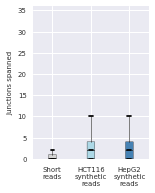

In [324]:
publishable = plotsettings.Set('Science')
publishable.set_figsize(n_columns = 1, n_rows = 2)


#http://nbviewer.ipython.org/gist/olgabot/5432378
#http://blog.bharatbhole.com/creating-boxplots-with-matplotlib/

data_to_plot = [short_junctions, HCT_long_junctions, Hep_long_junctions]
fig = plt.figure()
ax = fig.add_subplot(111)
bp = ax.boxplot(data_to_plot, widths=.2, notch=True, patch_artist=True)
ax.set_xticklabels(['Short\nreads', 'HCT116\nsynthetic\nreads', 
                    'HepG2\nsynthetic\nreads'])
ax.set_ylabel("Junctions spanned")
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

ax.set_ylim(0,36)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.setp(bp['whiskers'], linestyle='solid', color='black', linewidth=0.5)
plt.setp(bp['fliers'], color='black')
plt.setp(bp['caps'], color='black')
plt.setp(bp['medians'], color='black')

colors = ['lightgrey', 'lightblue', 'steelblue']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

plt.tight_layout()

# Save the figure
fig.show()
#fig.savefig('boxplotv2.pdf', format='pdf')

### Figure 3a: Length distribution of Env and  Figure 3b: Env discrimination

In [49]:
%cd ../Env

Env_cleanlengths = []
numClean = 0
with open("unique_contig_lengths", "r") as f:
    for line in f:
        if float(line) > 1000:
            Env_cleanlengths.append(float(line))
            numClean += 1
print numClean, "contigs longer than 1kb"

/Users/jimstapleton/Dropbox/Papers/Sequencing/Github/Env
1280 contigs longer than 1kb


In [50]:
%cd ../Env
MajMatch = []
with open("env1maxwRate", "r") as f:
    for line in f:
        MajMatch.append(float(line))

MinMatch = []
with open("env2maxwRate", "r") as f:
    for line in f:
        MinMatch.append(float(line))

/Users/jimstapleton/Dropbox/Papers/Sequencing/Github/Env


In [51]:
%cd ../Env/
MajMatchC1 = []
with open("E1C1maxwRate", "r") as f:
    for line in f:
        MajMatchC1.append(1-float(line))

MinMatchC1 = []
with open("E2C1maxwRate", "r") as f:
    for line in f:
        MinMatchC1.append(1-float(line))
    
MajMatchC2 = []
with open("E1C2maxwRate", "r") as f:
    for line in f:
        MajMatchC2.append(1-float(line))

MinMatchC2 = []
with open("E2C2maxwRate", "r") as f:
    for line in f:
        MinMatchC2.append(1-float(line))
    
MajMatchC3 = []
with open("E1C3maxwRate", "r") as f:
    for line in f:
        MajMatchC3.append(1-float(line))
MinMatchC3 = []
with open("E2C3maxwRate", "r") as f:
    for line in f:
        MinMatchC3.append(1-float(line))

/Users/jimstapleton/Dropbox/Papers/Sequencing/Github/Env


/Users/jimstapleton/Dropbox/Papers/Sequencing/Figures


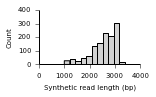

In [825]:
publishable = plotsettings.Set('Science')
publishable.set_figsize(n_columns = 1, n_rows = 1)

fig1, ax1 = plt.subplots()

plt.hist(Env_cleanlengths, bins=20, color='lightgrey')
plt.axis([0,4000,0,400])
plt.xlabel("Synthetic read length (bp)")
plt.ylabel("Count")
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
plt.tick_params(axis='both', which='major', direction='out')
plt.locator_params(nbins=4)
plt.tight_layout()

plt.show()
#plt.savefig('Figure3a.pdf', format='pdf')

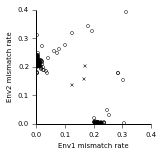

In [679]:
publishable.set_figsize(n_columns = 2, aspect_ratio=1)


fig, ax = plt.subplots()

plt.plot(MajMatch, MinMatch, 'o', alpha=.03, mfc='None') # plots open circles to emphasize density
plt.plot(MajMatchC1, MinMatchC1,'x', color='black') 
plt.plot(MajMatchC2, MinMatchC2,'x', color='black') 
plt.plot(MajMatchC3, MinMatchC3,'x', color='black') 

plt.xlabel("Env1 mismatch rate")
plt.ylabel("Env2 mismatch rate")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_aspect("equal")
plt.tick_params(axis='both', which='major', direction='out')
plt.locator_params(nbins=4)

plt.tight_layout()

plt.show()
#plt.savefig('Figure3c.pdf', format='pdf')

/Users/jimstapleton/Dropbox/Papers/Sequencing/Figures


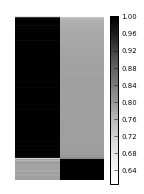

In [823]:
#http://stackoverflow.com/questions/14391959/heatmap-in-matplotlib-with-pcolor
MajMatch = [1-match for match in MajMatch]
MinMatch = [1-match for match in MinMatch]
data = np.array((MajMatch, MinMatch), dtype=float)
data = data.T
sorteddata = data[data[:,1].argsort()]
fig, ax = plt.subplots()
heatmap = ax.pcolor(sorteddata, cmap=plt.cm.Greys)
plt.axis('off')

ax.invert_yaxis()
ax.xaxis.tick_top()
fig.set_size_inches(2, 3)

ax.set_xticklabels(row_labels, minor=False)
ax.set_yticklabels(column_labels, minor=False)
cbar = plt.colorbar(heatmap)
#plt.tight_layout()

plt.show()
#plt.savefig('env_colormap.pdf', format='pdf')

### Supplemental length histograms

In [12]:
# Potato

%cd ../Potato/
potato_contiglengths = []
numContigs = 0
with open("contig_lengths", "r") as f:
    for line in f:
        if float(line) > 1000:
            potato_contiglengths.append(float(line))
            numContigs += 1
print numContigs, "longer than 1kb"

/Users/jimstapleton/Dropbox/Papers/Sequencing/Github/Potato
1509 longer than 1kb


In [13]:
# Potato

%cd ../Potato/
potato_contiglengths = []
numContigs = 0
with open("contig_lengths", "r") as f:
    for line in f:
        if float(line) > 1000:
            potato_contiglengths.append(float(line))
            numContigs += 1
print numContigs, "longer than 1kb"

/Users/jimstapleton/Dropbox/Papers/Sequencing/Github/Potato
1509 longer than 1kb


In [14]:
sumLength = 0
for contiglength in potato_contiglengths:
    sumLength += contiglength

N50sum = 0
for contiglength in potato_contiglengths:
    N50sum += contiglength
    if N50sum/float(sumLength) > 0.5:
        print "N50 is", contiglength
        break

N50 is 3279.0


In [29]:
# Gelsemium #2

%cd ../Gelsemium2/
JasmineR_contiglengths = []
numContigs = 0
with open("contig_lengths", "r") as f:
    for line in f:
        if float(line) > 1000:
            JasmineR_contiglengths.append(float(line))
            numContigs += 1
print numContigs, "longer than 1kb"

/Users/jimstapleton/Dropbox/Papers/Sequencing/Github/Gelsemium2
28574 longer than 1kb


In [27]:
sumLength = 0
for contiglength in JasmineR_contiglengths:
    sumLength += contiglength

N50sum = 0
for contiglength in JasmineR_contiglengths:
    N50sum += contiglength
    if N50sum/float(sumLength) > 0.5:
        print "N50 is", contiglength
        break

N50 is 2802.0


In [58]:
# Chicken

%cd ../Chicken
Chicken_contiglengths = []
numContigs = 0
with open("contig_lengths", "r") as f:
    for line in f:
        if float(line) > 1000:
            Chicken_contiglengths.append(float(line))
            numContigs += 1
print numContigs, "longer than 1kb"

/Users/jimstapleton/Dropbox/Papers/Sequencing/Github/Chicken
146501 longer than 1kb


In [337]:
sumLength = 0
for contiglength in Chicken_contiglengths:
    sumLength += contiglength

N50sum = 0
for contiglength in Chicken_contiglengths:
    N50sum += contiglength
    if N50sum/float(sumLength) > 0.5:
        print "N50 is", contiglength
        break

N50 is 2051.0


/Users/jimstapleton/Dropbox/Papers/Sequencing/Figures


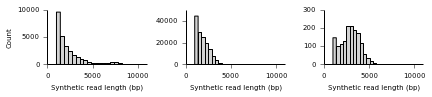

In [60]:
publishable = plotsettings.Set('Science')
publishable.set_figsize(n_columns = 2.5, n_rows = 1)

fig, ax = plt.subplots()

# Jasmine #2
ax1 = plt.subplot(131)
plt.hist(JasmineR_contiglengths, bins=30, color='lightgray')
plt.axis([0,11000,0,10000])
plt.xlabel("Synthetic read length (bp)")
plt.ylabel("Count")
plt.locator_params(nbins=3)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
plt.tick_params(axis='both', which='major', direction='out')


# Chicken
ax2 = plt.subplot(132)
plt.hist(Chicken_contiglengths, bins=15, color='lightgray')
plt.axis([0,11000,0,50000])
plt.xlabel("Synthetic read length (bp)")
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.xaxis.set_ticks_position('bottom')
ax2.yaxis.set_ticks_position('left')
plt.tick_params(axis='both', which='major', direction='out')
plt.locator_params(nbins=4)


# Potato
ax3 = plt.subplot(133)
plt.hist(potato_contiglengths, bins=15, color='lightgray')
plt.axis([0,11000,0,300])
plt.xlabel("Synthetic read length (bp)")
plt.locator_params(nbins=4)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.xaxis.set_ticks_position('bottom')
ax3.yaxis.set_ticks_position('left')
plt.tick_params(axis='both', which='major', direction='out')

plt.tight_layout()
plt.show()
#plt.savefig('supplemental_contigLengthHistogram.pdf', format='pdf')

### Barcode frequency histogram for Jasmine

In [52]:
%cd ../Gelsemium/
data = []
complexityBottleneck = 0
with open("histogram.txt", "r") as f:
    for line in f:
        data.append(float(line))
        complexityBottleneck += 1

/Users/jimstapleton/Dropbox/Papers/Sequencing/Github/Gelsemium


/Users/jimstapleton/Dropbox/Papers/Sequencing/Figures


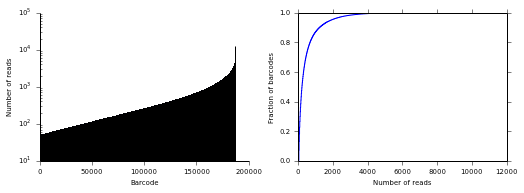

In [53]:
publishable = plotsettings.Set('Science')
publishable.set_figsize(3, 2) 


width = .1
data = sorted(data)
ind = np.arange(len(data))

fig, ax = plt.subplots()

ax1 = plt.subplot(121)
plt.bar(ind, data, log=1)
plt.xlabel("Barcode")
plt.ylabel("Number of reads")
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
plt.tick_params(axis='both', which='major', direction='out')

ax2 = plt.subplot(122)
plt.hist(data, 1000, normed=1, histtype='step', cumulative=True)
plt.xlabel("Number of reads")
plt.ylabel("Fraction of barcodes")
plt.axis([0,12000,0,1])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.tick_params(axis='both', which='major', direction='out')

plt.tight_layout()
plt.show()
#plt.savefig('Jasmine_barcodeFreqHistogram.pdf', format='pdf')

### GC content of synthetic long reads

In [5]:
%cd ../Gelsemium/
Gelsemium_GC = []
with open("gc_content.txt", "r") as f:
    for line in f:
        gc = line.split()[2]
        if gc != "%GC":
            Gelsemium_GC.append(float(gc))
print np.median(Gelsemium_GC)

/Users/jimstapleton/Dropbox/Papers/Sequencing/Github/Gelsemium
36.49


In [6]:
%cd ../Potato/
Potato_GC = []
with open("gc_content.txt", "r") as f:
    for line in f:
        gc = line.split()[2]
        if gc != "%GC":
            Potato_GC.append(float(gc))
print np.median(Potato_GC)

/Users/jimstapleton/Dropbox/Papers/Sequencing/Github/Potato
36.6


In [7]:
%cd ../MG1655/
MG1655_GC = []
with open("gc_content.txt", "r") as f:
    for line in f:
        gc = line.split()[2]
        if gc != "%GC":
            MG1655_GC.append(float(gc))
print np.median(MG1655_GC)

/Users/jimstapleton/Dropbox/Papers/Sequencing/Github/MG1655
51.08


In [8]:
%cd ../Chicken/
Chicken_GC = []
with open("gc_content.txt", "r") as f:
    for line in f:
        gc = line.split()[2]
        if gc != "%GC":
            Chicken_GC.append(float(gc))
print np.median(Chicken_GC)

/Users/jimstapleton/Dropbox/Papers/Sequencing/Github/Chicken
39.75


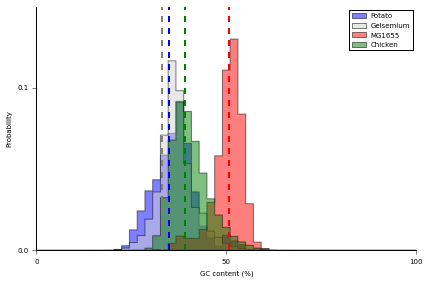

In [16]:
fig, ax = plt.subplots()

ax1 = plt.subplot(111)
bins = np.linspace(0, 100)

plt.hist(Potato_GC, bins=bins, histtype='stepfilled', color='blue', normed=1, alpha=0.5, label='Potato')
plt.hist(Gelsemium_GC, bins=bins, histtype='stepfilled', color='lightgray', normed=1, alpha=0.5, label='Gelsemium')
plt.hist(MG1655_GC, bins=bins, histtype='stepfilled', color='red', normed=1, alpha=0.5, label='MG1655')
plt.hist(Chicken_GC, bins=bins, histtype='stepfilled', color='green', normed=1, alpha=0.5, label='Chicken')

# Organism GC content:
# Potato: Nature 475, 189–195 (14 July 2011) doi:10.1038/nature10158
plt.axvline(34.8, color='blue', linestyle='dashed', linewidth=2)
# MG1655: Nucleic Acids Res 34:1-9 (2006)
plt.axvline(50.79, color='red', linestyle='dashed', linewidth=2)
# Chicken: Genome Res. 2005. 15: 1692-1698
plt.axvline(39, color='green', linestyle='dashed', linewidth=2)
# Gelsemium: 
plt.axvline(33, color='gray', linestyle='dashed', linewidth=2)

#plt.axis([0,11000,0,10000])
plt.xlabel("GC content (%)")
plt.ylabel("Probability")
plt.locator_params(nbins=3)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
plt.tick_params(axis='both', which='major', direction='out')

plt.legend()

plt.tight_layout()
plt.show()
#plt.savefig('GC_content.pdf', format='pdf')

###Env haplotype phasing analysis

In [3]:
%cd ../Env
Env1 = []
Env2 = []
with open("seqCountSum.txt", "r") as f:
    for line in f:
        Env1.append(float(line.split()[0]))
        Env2.append(float(line.split()[1]))

/Users/jimstapleton/Dropbox/Papers/Sequencing/Github/Env


In [4]:
import pandas as pd
import statsmodels.formula.api as smf

In [18]:
with open("seqCount.txt", "r") as f:
    data = pd.read_csv(f, index_col=0)
data.head()

,Env1_1 counts,Env1_2 counts,Env2_1 counts,Env2_2 counts
1,10,28,550,3401
2,0,1,2,18
3,0,3,31,9
4,2,1,36,3
5,24,0,0,0


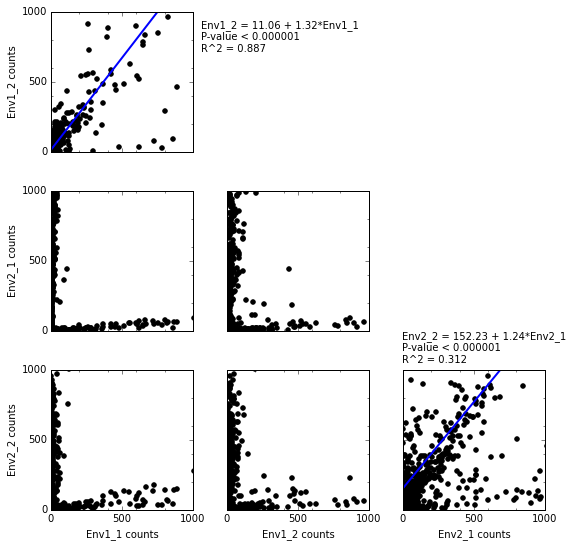

In [80]:
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True)
plt.axis([0,1000,0,1000])
plt.locator_params(nbins=4)
plt.tight_layout()

data.plot(kind='scatter', x='Env1_1 counts', y='Env1_2 counts', ax=axs[0,0], color='black', figsize=(8, 8))

data.plot(kind='scatter', x='Env1_1 counts', y='Env2_1 counts', ax=axs[1,0], color='black', sharex=True)
data.plot(kind='scatter', x='Env1_2 counts', y='Env2_1 counts', ax=axs[1,1], color='black', sharey=True)

data.plot(kind='scatter', x='Env1_1 counts', y='Env2_2 counts', ax=axs[2,0], color='black')
data.plot(kind='scatter', x='Env1_2 counts', y='Env2_2 counts', ax=axs[2,1], color='black')
data.plot(kind='scatter', x='Env2_1 counts', y='Env2_2 counts', ax=axs[2,2], color='black')

def corr1(E11):
    return 11.06+1.32*E11
t = np.arange(0, 1000, 10)
E1112 = corr1(t)
line, = axs[0,0].plot(t, E1112, lw=2)

def corr2(E21):
    return 152.23+1.24*E21
E2122 = corr2(t)
line, = axs[2,2].plot(t, E2122, lw=2)

fig.delaxes(axs[0,1])
fig.delaxes(axs[0,2])
fig.delaxes(axs[1,2])

plt.figtext(0.35, 0.88, 'Env1_2 = 11.06 + 1.32*Env1_1\nP-value < 0.000001\nR^2 = 0.887')
plt.figtext(0.7, 0.34, 'Env2_2 = 152.23 + 1.24*Env2_1\nP-value < 0.000001\nR^2 = 0.312')


plt.show()
#plt.savefig('Env_haplotyping.pdf', format='pdf')

In [69]:
lm1112 = smf.ols(formula='Env1_2 ~ Env1_1', data=data).fit()
lm1112.params

SyntaxError: unexpected EOF while parsing (<string>, line 1)

In [24]:
lm1112.conf_int()

,0,1
Intercept,-9.055148,31.182958
Env1_1,1.304645,1.343522


In [44]:
lm1112.pvalues

Intercept    0.280969
Env1_1       0.000000
dtype: float64

In [26]:
lm1112.rsquared


0.88731525952777601

In [27]:
lm1121 = smf.ols(formula='Env2_1 ~ Env1_1', data=data).fit()
lm1121.params

Intercept    270.730541
Env1_1         0.117421
dtype: float64

In [28]:
lm1121.conf_int()

,0,1
Intercept,204.128500,337.332581
Env1_1,0.053073,0.181770


In [29]:
lm1121.pvalues


Intercept    2.464740e-15
Env1_1       3.529762e-04
dtype: float64

In [30]:
lm1121.rsquared


0.0056191134023930722

In [31]:
lm1122 = smf.ols(formula='Env2_2 ~ Env1_1', data=data).fit()
lm1122.params

Intercept    482.475778
Env1_1         0.213228
dtype: float64

In [32]:
lm1122.conf_int()

,0,1
Intercept,334.570258,630.381297
Env1_1,0.070327,0.356129


In [33]:
lm1122.pvalues


Intercept    1.919803e-10
Env1_1       3.466594e-03
dtype: float64

In [34]:
lm1122.rsquared


0.0037642581805725772

In [35]:
lm1221 = smf.ols(formula='Env2_1 ~ Env1_2', data=data).fit()
lm1221.params

Intercept    266.830789
Env1_2         0.114396
dtype: float64

In [36]:
lm1221.pvalues

Intercept    5.278539e-15
Env1_2       9.632621e-07
dtype: float64

In [37]:
lm1221.rsquared

0.010537852979727202

In [38]:
lm1222 = smf.ols(formula='Env2_2 ~ Env1_2', data=data).fit()
lm1222.params

Intercept    470.965800
Env1_2         0.246753
dtype: float64

In [41]:
lm1222.pvalues

Intercept    4.525418e-10
Env1_2       1.915602e-06
dtype: float64

In [40]:
lm1222.rsquared

0.009960164125134785

In [42]:
lm2122 = smf.ols(formula='Env2_2 ~ Env2_1', data=data).fit()
lm2122.params

Intercept    152.239508
Env2_1         1.239149
dtype: float64

In [43]:
lm2122.pvalues

Intercept     1.647888e-02
Env2_1       3.247408e-186
dtype: float64

In [45]:
lm2122.rsquared

0.31193424284776561